In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [5]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

Cloning into 'SegNet-Tutorial'...
remote: Enumerating objects: 2785, done.
remote: Total 2785 (delta 0), reused 0 (delta 0), pack-reused 2785
Receiving objects: 100% (2785/2785), 340.84 MiB | 50.15 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
path = Path('/content/SegNet-Tutorial/CamVid')

In [7]:
path.ls()

[PosixPath('/content/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/SegNet-Tutorial/CamVid/train.txt')]

In [8]:
fnames=get_image_files(path/'val')
fnames[0:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08067.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08115.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/val/0016E5_08007.png')]

In [9]:
lbl_names=get_image_files(path/'valannot')
lbl_names[0:3]

[PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08067.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08115.png'),
 PosixPath('/content/SegNet-Tutorial/CamVid/valannot/0016E5_08007.png')]

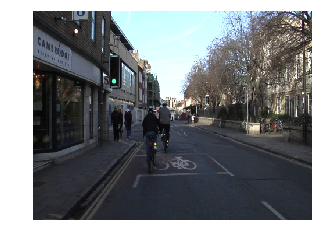

In [10]:
img_f=fnames[0]
img=open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

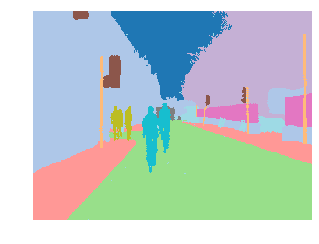

In [13]:
mask=open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [14]:
src_size=np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

In [0]:
bs=4
size=src_size//2

In [0]:
src=(SegmentationItemList.from_folder(path).split_by_folder(valid='val').label_from_func(get_y_fn,classes=codes))

In [0]:
data=(src.transform(get_transforms(),tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

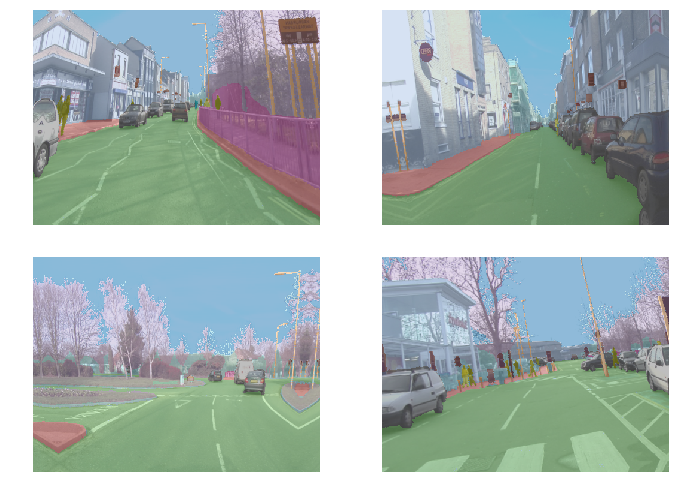

In [18]:
data.show_batch(2,figsize=(10,7))

In [0]:
name2id={v:k for k,v in enumerate(codes)}
void_code=name2id['Void']

def acc_camvid(input,target):
  target=target.squeeze(1)
  mask=target!=void_code
  return(input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [24]:
learn=unet_learner(data,models.resnet34,metrics=metrics,wd=wd,bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 16499719.25it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


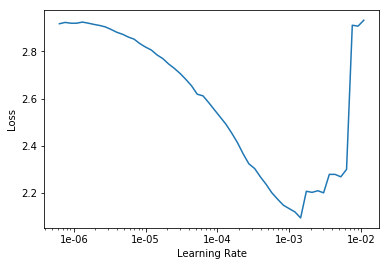

In [26]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [28]:
learn.fit_one_cycle(8,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.944446,0.776487,0.786733,00:52
1,0.650153,0.533024,0.854344,00:48
2,0.524856,0.653848,0.778216,00:48
3,0.480069,0.594574,0.825584,00:47
4,0.475118,0.412445,0.880189,00:47
5,0.444667,0.527614,0.818023,00:47
6,0.386460,0.324397,0.899869,00:47
7,0.317608,0.272050,0.914744,00:47


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
lrs=slice(lr/100,lr)

In [34]:
learn.fit_one_cycle(8,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.285867,0.264460,0.920008,00:51
1,0.273382,0.299841,0.905133,00:50
2,0.280535,0.316785,0.903567,00:50
3,0.304326,0.361672,0.902825,00:50
4,0.324231,0.482706,0.854092,00:50
5,0.314215,0.287263,0.917051,00:50
6,0.296289,0.287700,0.913966,00:50
7,0.244695,0.256083,0.927461,00:50


In [0]:
learn.save('stage_2')

In [36]:
learn=None
gc.collect()

6462

In [0]:
size=src_size
bs=8

In [0]:
data=(src.transform(get_transforms(),size=size,tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

In [0]:
learn=unet_learner(data,models.resnet34,metrics=metrics,wd=wd,bottle=True).load('stage_2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


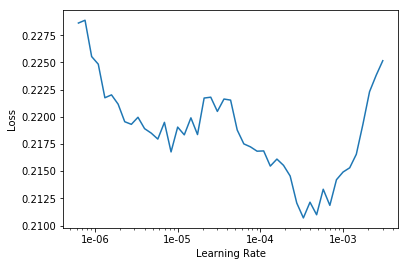

In [40]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=7e-4

In [42]:
learn.fit_one_cycle(8,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.216265,0.252853,0.927889,00:49
1,0.211750,0.258593,0.926112,00:44
2,0.207572,0.258490,0.924367,00:44
3,0.205220,0.235325,0.932461,00:44
4,0.208724,0.268355,0.919791,00:44
5,0.205588,0.239122,0.931155,00:44
6,0.200152,0.275666,0.919612,00:44
7,0.187916,0.225800,0.937410,00:44


In [0]:
learn.save('big1')

In [0]:
learn.unfreeze()

In [0]:
lrs=slice(lr/1000,lr/10)

In [49]:
learn.fit_one_cycle(8,lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.167851,0.223568,0.937793,00:48
1,0.166883,0.232495,0.934928,00:46
2,0.165863,0.234669,0.934707,00:47
3,0.162511,0.233958,0.934611,00:47
4,0.161531,0.232428,0.935314,00:46
5,0.160837,0.234753,0.935118,00:47
6,0.158108,0.233167,0.935665,00:46
7,0.156667,0.236667,0.934874,00:47


In [0]:
#Second time worsened it so we'll be sticking with big1 :)